In [13]:
import os
import xml.etree.ElementTree as etree
from glob import glob

import cv2
import torch.nn as nn
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.optim as optim
from torchvision.models.detection import FasterRCNN

from utils import plot_box

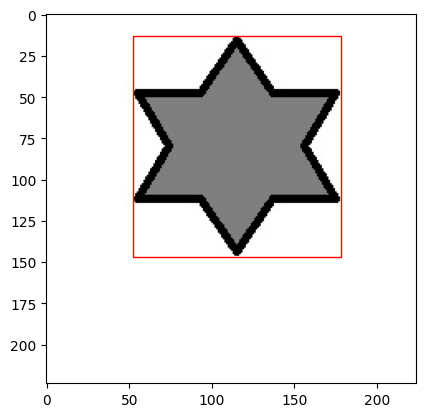

In [8]:
class ShapeDetection(Dataset):
    def __init__(self, images_path, annots_path):
        self.images = glob(os.path.join(images_path, '*.jpg'))
        self.annots_path = annots_path

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            # transforms.Grayscale(),
        ])

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img_path = self.images[index]
        img_name = os.path.basename(os.path.splitext(img_path)[0])
        xml_path = os.path.join(self.annots_path, img_name + '.xml')

        xml_root = etree.parse(xml_path).getroot()
        box_elems = list(xml_root.find('object').find('bndbox').iter())[1:]

        xmin, ymin, xmax, ymax = [float(elem.text) for elem in box_elems]

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = self.transform(img)

        return img, {
            'boxes': torch.tensor([[xmin, ymin, xmax, ymax]]),
            'labels': torch.tensor([1])
        }

    @staticmethod
    def collate_fn(x):
        return list(zip(*x))


dataset = ShapeDetection('./data/shape/images', './data/shape/annotations')
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=dataset.collate_fn)
sample_img, target = dataset[10]
plt.imshow(sample_img.permute(1, 2, 0), cmap='gray')

plot_box(target['boxes'][0])

In [9]:
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(
    weights=models.detection.FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT)


In [10]:
# fine tune
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(
    model.roi_heads.box_predictor.cls_score.in_features, 2)

# freeze parameters
for p in model.backbone.parameters():
    p.requires_grad = False



In [29]:
class RPNOnlyFasterRCNN(FasterRCNN):
    def __init__(self):
        print("fuck why is this harder than i thought")

In [114]:
opt = optim.SGD([p for p in model.parameters() if p.requires_grad], 1e-2, momentum=0.9, weight_decay=5e-4)

In [115]:
model.train()
epochs = 1

for epoch in range(epochs):
    for img, target in dataloader:
        loss_dict = model(img, target)
        loss = sum(loss_dict.values())
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        print(f'done with epoch {epoch}')

done with epoch 0
done with epoch 0
done with epoch 0
done with epoch 0
done with epoch 0
done with epoch 0
done with epoch 0
done with epoch 0
done with epoch 0
done with epoch 0
done with epoch 0
done with epoch 0
done with epoch 0
done with epoch 0


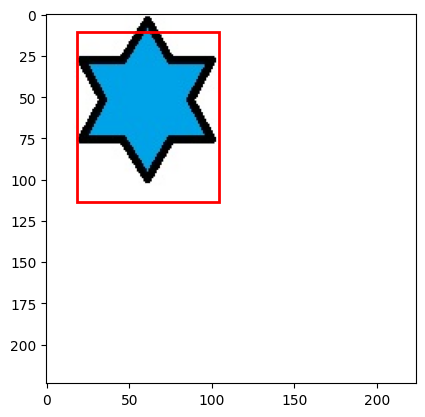

In [132]:
model.eval()
sample_img, _ = dataset[100]
x1, y1, x2, y2 = model(sample_img[None])[0]['boxes'][0]
x1 = x1.item()
y1 = y1.item()
x2 = x2.item()
y2 = y2.item()

plt.imshow(sample_img.permute(1, 2, 0), cmap='gray')
plt.gca().add_patch(
    plt.Rectangle((x1, y1), x2 - x1, y2-y1, fill=False, edgecolor='red', linewidth=2))